_Version log: Branch of V19. Optimisation using MCMC Metropolis._

In [96]:
import sys, time
import numpy as np
import CS_functions as cs
from matplotlib import pyplot as plt
from scipy import fft as spfft, interpolate as spinter
from tqdm import tqdm

plt.rcParams.update({'font.size':24, 'image.origin': 'lower', 'xtick.minor.visible': True, 'ytick.minor.visible': True, 'lines.linewidth': 2.4, 'figure.facecolor': 'none', 'axes.facecolor': 'white'})
np.set_printoptions(threshold=sys.maxsize)

In [97]:
#file_number = 15
#file_name = "1dmockanderrors{:d}".format(file_number)
file_name = "240802134128_altered1d"
file_type = ".csv"

target, uncertainties = cs.open_dataset(file_name, ".csv")
optlocs_file = "data\\" + file_name +"_optlocs.csv"

In [98]:
#target = cs.generate_interferogram(200, 200e-6, 3e12, 0.1e12, 1.0)
#uncertainties = np.ones_like(interferogram)

In [99]:
reduced_points = 8
regularization_coeffient = 1e-3 # DECREASE FOR COMPLEX IMAGES (up to 1e-7 (floating point error?)) INCREASE FOR SIMPLE IMAGES (up to 1e-2)
idx = np.arange(len(target))

In [100]:
start_time = time.time()

detectors = np.array([], dtype= int)

new_detector = np.argmax(np.abs(target)) # Without any samples, CS cannot find any frequencies so all amplitudes will go to zero. DP wants to locate the point that is furthest away from this zero line. Hence, this is a sensible way to intitalise the loop.
detectors = np.append(detectors, new_detector)

for n in range(1,reduced_points):
    samples = np.full_like(target, np.nan)
    samples[detectors] = target[detectors]
    result = cs.compressed_sensing(samples, regularization_coeffient, ignore_mean= False, dct_type= 1)

    new_detector = np.argsort(np.abs(target -result))[::-1] # argsort sorts from smallest to largest but I want largest to smallest
    new_detector = np.setdiff1d(new_detector, detectors, assume_unique= True)[0] # pick the first (largest) item
    detectors = np.append(detectors, new_detector)

samples = np.full_like(target, np.nan)
samples[detectors] = target[detectors]
result = cs.compressed_sensing(samples, regularization_coeffient, ignore_mean= False, dct_type= 1)

end_time = time.time()
print(end_time -start_time)

0.022731542587280273


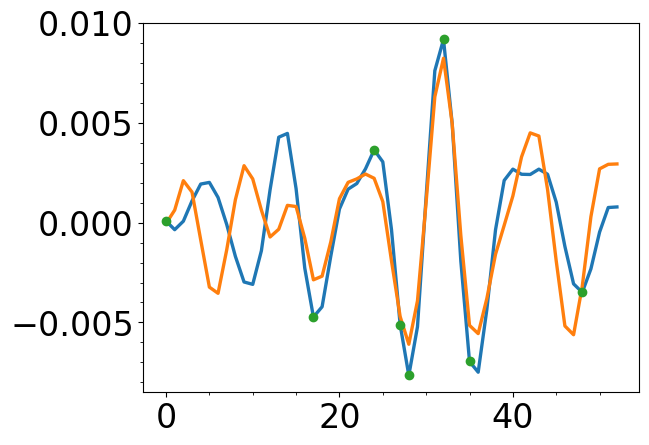

0.016938799148614937


In [101]:
plt.plot(idx, target)
plt.plot(idx, result)
plt.plot(idx[detectors], target[detectors], marker= "o", linestyle= "none")
plt.show()

print(cs.evaluate_score(detectors, target, uncertainties, regularization_coeffient= regularization_coeffient))

In [102]:
samples = np.full_like(target, np.nan)
samples[detectors] = target[detectors]
result = cs.compressed_sensing(samples, regularization_coeffient)
score = cs.evaluate_score(detectors, target, uncertainties, regularization_coeffient)

cs.append_array_to_csv(detectors, optlocs_file)
print(score)

0.016938799148614937


In [103]:
print(*detectors, sep= ",")

32,48,35,24,17,28,0,27


## FWHM graph

In [110]:
regularization_coeffient = 1e-3
max_samples = 200

array_length = 400
pixel_pitch = 200e-6
FWHMs = np.arange(0.3e12, 6e12, 0.05e12)
central_freq = 3e12
theta = 1.0

scores = np.full((max_samples, len(FWHMs)), np.nan)

for m, FWHM in tqdm(enumerate(FWHMs)):
    interferogram = cs.generate_interferogram(array_length, pixel_pitch, central_freq, FWHM, theta)
    uncertainty = np.ones_like(interferogram)

    detectors, _ = cs.douglas_peucker(max_samples, interferogram, uncertainty, regularization_coeffient= regularization_coeffient)

    for n in range(max_samples):
        scores[n, m] = cs.evaluate_score(detectors[:n+1], interferogram, uncertainty, regularization_coeffient= regularization_coeffient, domain= "IDCT")


0it [00:00, ?it/s]

114it [12:25,  6.54s/it]


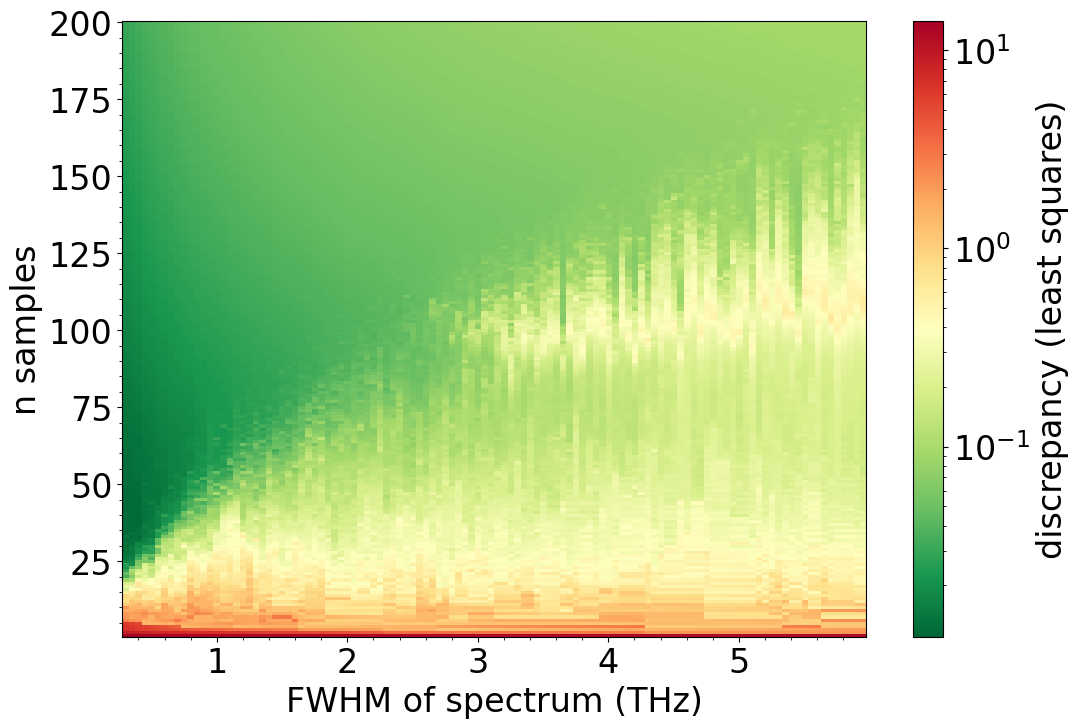

In [111]:
fig, axs = plt.subplots(1, 1, figsize= (12, 8))

im = axs.imshow(scores,
                aspect= "auto",
                interpolation= "none",
                norm= "log",
                cmap= "RdYlGn_r",
                extent= ((1.5*FWHMs[0]-0.5*FWHMs[1]) *1e-12, (1.5*FWHMs[-1]-0.5*FWHMs[-2]) *1e-12, 0.5, max_samples +0.5))

axs.set(xlabel= "FWHM of spectrum (THz)", ylabel= "n samples")

fig.colorbar(im, label= "discrepancy (least squares)")
plt.show()